# General
* Online documentation: https://gpyopt.readthedocs.io/en/latest/
* Tutorials: http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb

## Tutorial 1 - One dimensional example
From 'Introduction to Bayesian Optimization with GPyOpt' - http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_reference_manual.ipynb

In [28]:
%pylab inline  
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib


Populating the interactive namespace from numpy and matplotlib


In [6]:
def myf(x):
    return (2*x)**2

### Simple example of optimization
The function myf has a minimum at x=0. We set the domain in which to look for that extremum to [-1,1] and use 15 iterations to find the extremum

In [8]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)}]
max_iter = 15

In [29]:
myProblem = GPyOpt.methods.BayesianOptimization(myf,bounds)

In [30]:
myProblem.run_optimization(max_iter)

In [31]:
# Optimal x
print("x_opt=" + str(myProblem.x_opt))
# Function value at x_opt
print("f(x_opt)=" + str(myProblem.fx_opt))

x_opt=[0.]
f(x_opt)=0.0


### One dimensional example
Consider $f(X)= (6x-2)^2 \sin(12x-4)$ for $x \in [0,1]$. We know that $x_{min}=0.78$

In [32]:
%pylab inline  
import GPy
import GPyOpt

# Create the true and perturbed Forrester function and the boundaries of the problem
f_true= GPyOpt.objective_examples.experiments1d.forrester()          # noisy version
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]  # problem constraints 

Populating the interactive namespace from numpy and matplotlib


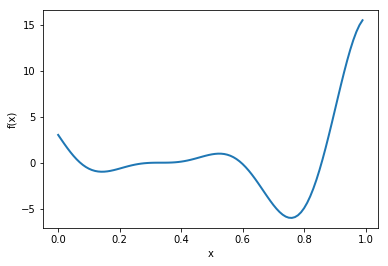

In [35]:
f_true.plot()

In [18]:
# Creates GPyOpt object with the model and anquisition fucntion
seed(123)
myBopt = GPyOpt.methods.1(f=f_true.f,            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = True) # Selects the Expected improvement

In [19]:
# Run the optimization
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps)

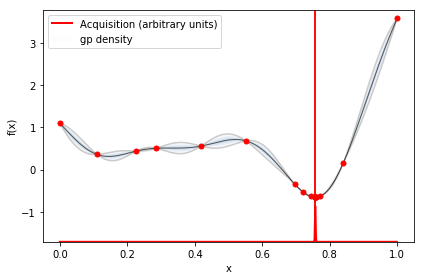

In [34]:
myBopt.plot_acquisition()

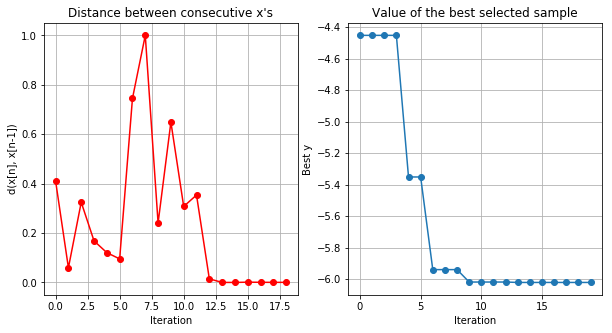

In [42]:
myBopt.plot_convergence()

## Configuring Scikit-learn methods
### Part I: Regression
Tune hyper-parameters for Support Vector Regression (SVR) implemented in Scikit-learn. Given the standard interface of Scikit-learn, other models can be tuned in a similar fashion.

In [44]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn import svm
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


For this example we will use the Olympic marathon dataset available in GPy. We split the original dataset into the training data (first 20 data points) and testing data (last 7 data points). The performance of SVR is evaluated in terms of Rooted Mean Squared Error (RMSE) on the testing data.

In [45]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20,0]
X_test = X[20:]
Y_test = Y[20:,0]

olympicMarathonTimes.csv
[==============================]   0.001/0.001MB                                                


In [46]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
print("The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma))

The default parameters obtained: C=1.0, epilson=0.1, gamma=auto_deprecated


RMSE = 0.5633074061198649


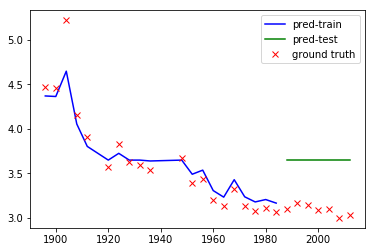

In [47]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

Now let's try Bayesian Optimization. We first write a wrap function for fitting with SVR. The objective is the RMSE from cross-validation. We optimize the parameters in log space.

In [48]:
nfold = 3
def fit_svr_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svr = svm.SVR(C=x[i,0], epsilon=x[i,1],gamma=x[i,2])
            svr.fit(X_train[idx_train],Y_train[idx_train])
            fs[i] += np.sqrt(np.square(svr.predict(X_train[idx_valid])-Y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

In [49]:
domain       =[{'name': 'C',      'type': 'continuous', 'domain': (0.,7.)},
               {'name': 'epsilon','type': 'continuous', 'domain': (-12.,-2.)},
               {'name': 'gamma',  'type': 'continuous', 'domain': (-12.,-2.)}]

In [50]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

The set cost function is ignored! LCB acquisition does not make sense with cost.


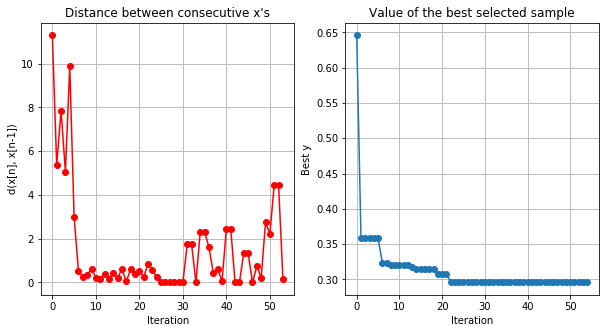

In [51]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [52]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
print("The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2]))
svr = svm.SVR(C=x_best[0], epsilon=x_best[1],gamma=x_best[2])
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

The best parameters obtained: C=1.0, epilson=0.003939188811835608, gamma=8.43682239109811e-05


RMSE = 0.08026116254044965


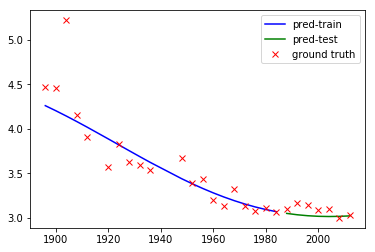

In [53]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))